In [1]:
from iyakovlev import random_rooted_unicellular_map, num_rooted_unicellular_maps

In [2]:
random_rooted_unicellular_map?

Signature:      random_rooted_unicellular_map(g, ne)
Docstring:     
   Generates a uniformly random rooted unicellular map of genus g with
   ne edges, and returns its vertex permutation, assuming the face
   permutation is (1,2,...,2*ne). The root half-edge is labeled with
   1.

   The algorithm is based on the CFF bijection from the paper
      Chapuy, Guillaume; Féray, Valentin; Fusy, Éric; A simple model
      of trees for unicellular maps. J. Comb. Theory, Ser. A 120, No.
      8, 2064-2092 (2013).
Init docstring: Initialize self.  See help(type(self)) for accurate signature.
File:           ~/sage_projects/iyakovlev/unicellular_generation.py
Type:           function

### Sanity checks

In [3]:
g,ne = 2,6
m = random_rooted_unicellular_map(g,ne)
print('Vertex permutation:', m.cycle_tuples())

# check that edge permutation is an involution without fixed points
ep = Permutation([i%(2*ne)+1 for i in range(1,2*ne+1)])*m.inverse()
assert all(len(i)==2 for i in ep.cycle_tuples())
print('Edge permutation:', ep.cycle_tuples() )

# check Euler's relation
nv = len(m.cycle_tuples())
assert nv-ne+1==2-2*g

Vertex permutation: [(1, 4, 7, 9, 12, 11, 10), (2, 6, 5, 3), (8,)]
Edge permutation: [(1, 3), (2, 5), (4, 6), (7, 8), (9, 11), (10, 12)]


### Let's check that the distribution is uniform

In [4]:
from collections import defaultdict
num = num_rooted_unicellular_maps(g,ne)
print('Number of maps:', num)
stat = defaultdict(int)
N = 40 # average number of hits of each map

Number of maps: 6468


In [5]:
%%time
for i in range(num*N):
    stat[random_rooted_unicellular_map(g,ne)]+=1

CPU times: user 1min 13s, sys: 5 ms, total: 1min 13s
Wall time: 1min 13s


In [6]:
print('Number of different maps hit:', len(stat))

Number of different maps hit: 6468


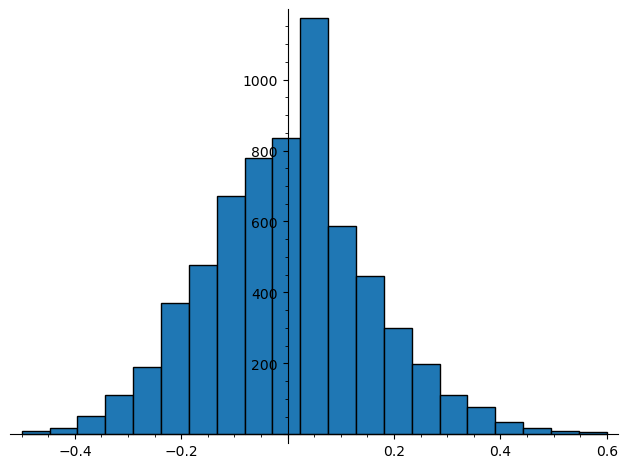

In [7]:
# relative errors
histogram([(stat[i]-N)/N for i in stat],bins=21)

### Let's check the distribution of the number of short cycles
According to the paper 

> Janson, Svante; Louf, Baptiste; Short cycles in high genus unicellular maps.<br>
Ann. Inst. Henri Poincaré, Probab. Stat. 58, No. 3, 1547-1564 (2022)

when $g,n \rightarrow \infty$ with $g/n \rightarrow \theta \in (0,1/2)$, the number of simple closed cycles of length $k$ in a random unicellular map of genus $g$ with $n$ edges converges to a Poisson distribution with an explicit parameter $\lambda_k$, depending on $\theta$.

Let's check this.

In [8]:
# some auxiliary functions
def to_graph(m):
    he_to_v = {} # half-edge to vertex
    for i,v in enumerate(m.cycle_tuples()):
        for j in v:
            he_to_v[j]=i
    ne = len(m)/2
    ep = Permutation([i%(2*ne)+1 for i in range(1,2*ne+1)])*m.inverse()
    G = Graph([(he_to_v[i],he_to_v[j]) for i,j in ep.cycle_tuples()], format='list_of_edges', loops=True, multiedges=True)
    return G

def num_of_simple_cycles_based(G, length, v, prev):
    res = 0
    for v1,v2 in G.edges_incident(v,labels=False):
        new_v = v1 if v1!=v else v2
        if new_v==prev[0] and len(prev)==length:
            res+=1
        elif new_v not in prev and len(prev)<length:
            res+=num_of_simple_cycles_based(G,length, v=new_v, prev=prev+[new_v])
    if length==2 and len(prev)==2:
        res-=1 #don't count the same edge traversed twice
    return res

def num_of_simple_cycles(G, length):
    assert length>=1
    res = sum(num_of_simple_cycles_based(G,length,i,[i]) for i in G.vertices())/length
    if length==1:
        return res
    else:
        return res/2

In [9]:
%%time
from collections import defaultdict
g=35
ne = 6*g-3 # theta = 1/6
max_length=3 # max length of simple cycle
N=2000 # number of maps to generate
stats = [defaultdict(int) for i in range(max_length)]
for i in range(N):
    m = random_rooted_unicellular_map(g,ne)
    G = to_graph(m)
    for i in range(max_length):
        stats[i][num_of_simple_cycles(G,i+1)]+=1

CPU times: user 1min 13s, sys: 16 ms, total: 1min 13s
Wall time: 1min 13s


In [10]:
# compute the parameters of the Poisson distributions
eq = (1-x**2)*(log(1+x)-log(1-x))-2*x*2/3 == 0
tau = eq.find_root(0,1)
lmbda = [1/(2*i) * ((1+tau)**i/(1-tau)**i + (1-tau)**i/(1+tau)**i - 2) for i in range(1,max_length+1)]

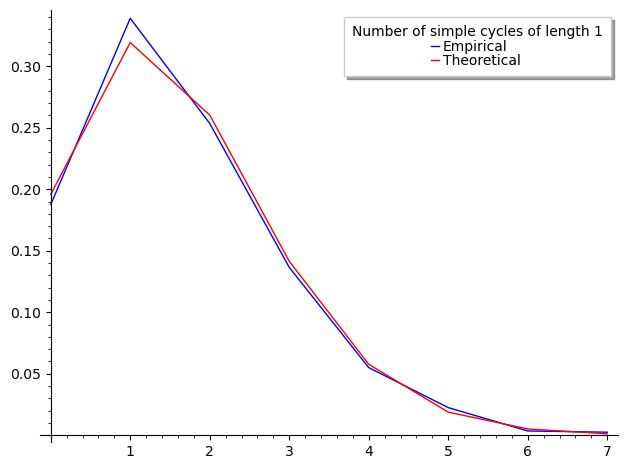

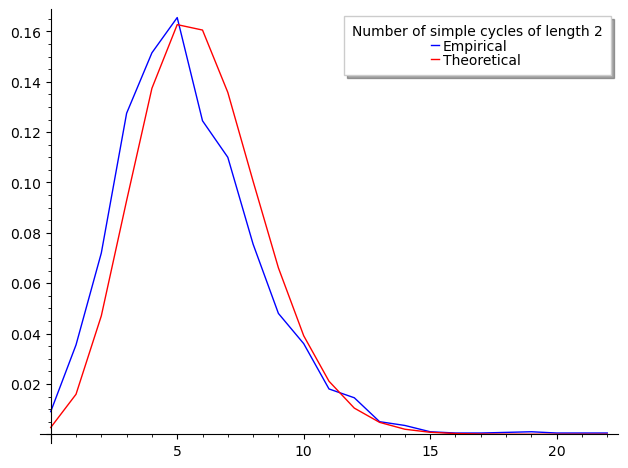

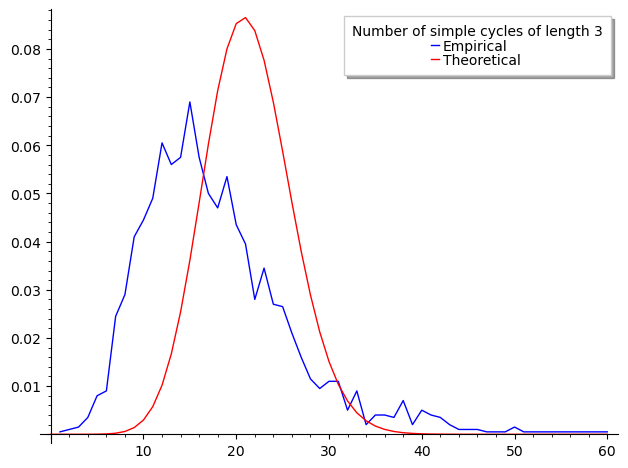

In [11]:
for i in range(max_length):
    pl1 = list_plot(sorted([(j,stats[i][j]/N) for j in stats[i]]) ,plotjoined=True,legend_label='Empirical')
    pl2 = list_plot([(j, exp(-lmbda[i])*lmbda[i]^j/factorial(j) ) for j in range(max(j for j in stats[i])+1)], 
                    plotjoined=True, color='red',legend_label='Theoretical')
    pl = pl1+pl2
    pl.set_legend_options(title="Number of simple cycles of length "+str(i+1))
    pl.legend(True)
    pl.show()